# 🔥 InternVL 3.5 Model Attribution

In [1]:
import os
os.chdir("../")

# Set the huggingface mirror and cache path
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com" # for Chinese
os.environ["HF_HOME"] = "./model_checkpoint/hf_cache"

from transformers import AutoTokenizer, AutoModel, AutoProcessor, AutoConfig, AutoModelForImageTextToText

import torch
from torch import nn
import torchvision.transforms.functional as TF

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from interpretation.submodular_vision import MLLMSubModularExplanationVision

from utils import SubRegionDivision
from visualization.visualization import visualization_mllm, visualization_mllm_with_object

/home/cry/anaconda3/envs/internvl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def imshow(img):
    """
    Visualizing images inside jupyter notebook
    """
    plt.axis('off')
    if len(img.shape)==3:
        img = img[:,:,::-1] 	# transform image to rgb
    else:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    plt.imshow(img)
    plt.show()

In [3]:
class InternVLAdaptor(torch.nn.Module):
    def __init__(self, 
                 model,
                 processor,
                 device = "cuda"):
        super().__init__()
        self.model = model
        self.device = device
        self.softmax = nn.Softmax(dim=-1)
        
        self.processor = processor
        
        self.text_prompt = None
        self.generated_ids = None
        
        # The position of the token that needs to be explained in the newly generated content (include all tokens)
        self.target_token_position = None
        self.selected_interpretation_token_word_id = None
        
    def forward(self, image):
        """_summary_

        Args:
            image: PIL format
        """
        if isinstance(image, torch.Tensor):
            if image.shape[-1] == 3:
                image_tensor = image[..., [2, 1, 0]]  # BGR → RGB
                image_tensor = image_tensor.permute(2, 0, 1)
                image_tensor = image_tensor.clamp(0, 255).byte()
                image = TF.to_pil_image(image_tensor)
                
        info = [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "image": image,
                    },
                    {"type": "text", "text": self.text_prompt},
                ],
            },
        ]
        
        # Preparation for inference
        inputs = self.processor.apply_chat_template(info, add_generation_prompt=True, tokenize=True, return_dict=True, return_tensors="pt").to(self.model.device, dtype=torch.bfloat16)
        
        self.generated_ids = self.generated_ids[:max(self.target_token_position)]   #bug
        inputs['input_ids'] = self.generated_ids
        inputs['attention_mask'] = torch.ones_like(self.generated_ids)
        inputs = inputs.to(self.model.device)    # dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_grid_thw'])
        
        # Forward calculation to get all logits (including the logits of the input part)
        with torch.no_grad():
            outputs = self.model(
                **inputs,
                return_dict=True,
                use_cache=True,
            )
            all_logits = outputs.logits  # [batch_size, seq_len, vocab_size]
        
        if self.generated_ids != None:
            returned_logits = all_logits[:, self.target_token_position - 1] # The reason for the minus 1 is that the generated content is in the previous position
            returned_logits = self.softmax(returned_logits)
            
            if self.selected_interpretation_token_word_id != None:
                self.selected_interpretation_token_word_id = torch.tensor(self.selected_interpretation_token_word_id).to(self.model.device)
                indices = self.selected_interpretation_token_word_id.unsqueeze(0).unsqueeze(-1) # [1, N, 1]
                
                returned_logits = returned_logits.gather(dim=2, index=indices) # [1, N, 1]
                
                returned_logits = returned_logits.squeeze(-1)  # [1, N]
        return returned_logits[0]   # size [N]

## Load the InternVL Model

In [4]:
# Load InternVL
model_name = "OpenGVLab/InternVL3_5-4B-HF"
# default: Load the model on the available device(s)
model = AutoModelForImageTextToText.from_pretrained(
    model_name,
    dtype=torch.bfloat16,
    device_map="auto",
    attn_implementation="sdpa",
    trust_remote_code=True).eval()

# default processor
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True, use_fast=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True, use_fast=False)

# Encapsulation Qwen
InternVL = InternVLAdaptor(
    model = model,
    processor = processor
)

Fetching 3 files: 100%|██████████| 3/3 [00:00<00:00, 8917.73it/s]


# Load the Explainer

In [5]:
explainer = MLLMSubModularExplanationVision(
    InternVL
)

cuda


# Load the Image

In [3]:
image_path = "./examples/cat_on_a_tree.jpg"
text_prompt = "Describe the image in one factual English sentence of no more than 20 words. Do not include information that is not clearly visible."
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_path,
            },
            {"type": "text", "text": text_prompt},
        ],
    }
]

In [4]:
# Preparation for inference
inputs = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=True, return_dict=True, return_tensors="pt").to(model.device, dtype=torch.bfloat16)

# Inference: Generation of the output
with torch.no_grad():
    generated_ids = model.generate(
        **inputs, 
        do_sample=False,      # Disable sampling and use greedy search instead
        num_beams=1,          # Set to 1 to ensure greedy search instead of beam search.
        max_new_tokens=128)
    generated_ids_trimmed = [   # 去掉图像和prompt的文本
        out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]
    
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
output_words = processor.batch_decode(
    generated_ids_trimmed[0], skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)
print(output_words)
print(generated_ids_trimmed)

NameError: name 'processor' is not defined

## 😮 Sentence-level Interpretation

In [ ]:
# Select all words to explain
selected_interpretation_token_id = [i for i in range(len(output_words))]
selected_interpretation_token_word_id = generated_ids_trimmed[0].tolist()

In [ ]:
## Equip the model with the generated ids and the target token position to be explained
InternVL.generated_ids = generated_ids
InternVL.target_token_position = np.array(selected_interpretation_token_id) + len(inputs['input_ids'][0])
InternVL.selected_interpretation_token_word_id = selected_interpretation_token_word_id

In [ ]:
# Image division
image = cv2.imread(image_path)
    
# Sub-region division
region_size = int((image.shape[0] * image.shape[1] / 50) ** 0.5)
V_set = SubRegionDivision(image, region_size = region_size)

In [ ]:
## Begin to explain
S_set, saved_json_file = explainer(image, V_set)
saved_json_file["selected_interpretation_token_id"] = selected_interpretation_token_id
saved_json_file["selected_interpretation_token_word_id"] = selected_interpretation_token_word_id
saved_json_file["words"] = output_words

  0%|          | 0/48 [00:00<?, ?it/s]/tmp/ipykernel_333181/1331877229.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.selected_interpretation_token_word_id = torch.tensor(self.selected_interpretation_token_word_id).to(self.model.device)
100%|██████████| 48/48 [45:13<00:00, 56.53s/it]  


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

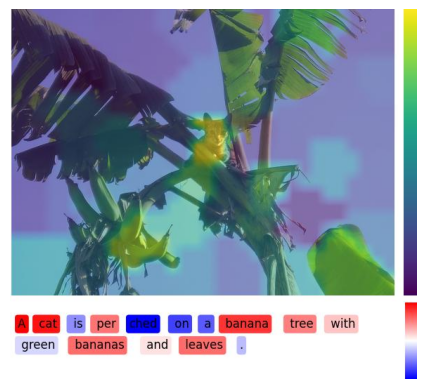

In [ ]:
## Visualization
visualization_mllm(image_path, S_set, saved_json_file, save_path="examples/explanation_internvl_cat_on_a_tree.jpg")
sentence_level_visualization_img = cv2.imread("examples/explanation_internvl_cat_on_a_tree.jpg")
imshow(sentence_level_visualization_img)

## 😮 Word-level Interpretation
In this case, we take the explanation word `cat` as an example

In [ ]:
# Select all words to explain
selected_interpretation_token_id = [1]
selected_interpretation_token_word_id = [generated_ids_trimmed[0][1].item()]

## Equip the model with the generated ids and the target token position to be explained
InternVL.generated_ids = generated_ids
InternVL.target_token_position = np.array(selected_interpretation_token_id) + len(inputs['input_ids'][0])
InternVL.selected_interpretation_token_word_id = selected_interpretation_token_word_id

In [ ]:
# Image division
image = cv2.imread(image_path)
    
# Sub-region division
region_size = int((image.shape[0] * image.shape[1] / 50) ** 0.5)
V_set = SubRegionDivision(image, region_size = region_size)

In [ ]:
## Begin to explain
S_set, saved_json_file = explainer(image, V_set)
saved_json_file["selected_interpretation_token_id"] = selected_interpretation_token_id
saved_json_file["selected_interpretation_token_word_id"] = selected_interpretation_token_word_id

  0%|          | 0/48 [00:00<?, ?it/s]/tmp/ipykernel_333181/1331877229.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.selected_interpretation_token_word_id = torch.tensor(self.selected_interpretation_token_word_id).to(self.model.device)
100%|██████████| 48/48 [43:46<00:00, 54.71s/it]  


0.988250732421875


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

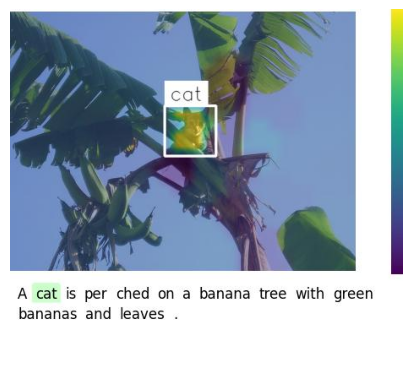

In [ ]:
## Visualization
saved_json_file["location"] = [286,174,381,267]
saved_json_file["select_category"] = "cat"
saved_json_file["output_words"] = output_words

visualization_mllm_with_object(image_path, S_set, saved_json_file, save_path="examples/explanation_internvl_word_cat_on_a_tree.jpg")
word_level_visualization_img = cv2.imread("examples/explanation_internvl_word_cat_on_a_tree.jpg")
imshow(word_level_visualization_img)

We can also try to explain the word `banana`

In [ ]:
# Select word bananas to explain
selected_interpretation_token_id = [11]
selected_interpretation_token_word_id = [generated_ids_trimmed[0][11].item()]

## Equip the model with the generated ids and the target token position to be explained
InternVL.generated_ids = generated_ids
InternVL.target_token_position = np.array(selected_interpretation_token_id) + len(inputs['input_ids'][0])
InternVL.selected_interpretation_token_word_id = selected_interpretation_token_word_id

In [ ]:
## Begin to explain
S_set, saved_json_file = explainer(image, V_set)
saved_json_file["selected_interpretation_token_id"] = selected_interpretation_token_id
saved_json_file["selected_interpretation_token_word_id"] = selected_interpretation_token_word_id

100%|██████████| 48/48 [45:15<00:00, 56.56s/it]  


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


0.826171875


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

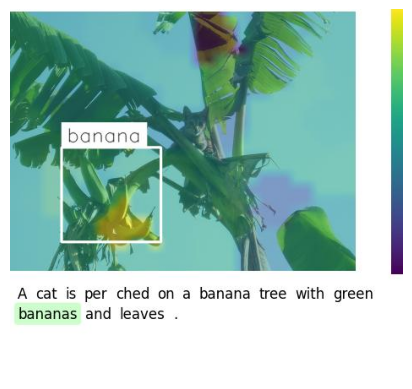

In [ ]:
## Visualization
saved_json_file["location"] = [95, 251, 279, 426]
saved_json_file["select_category"] = "banana"
saved_json_file["output_words"] = output_words

visualization_mllm_with_object(image_path, S_set, saved_json_file, save_path="examples/explanation_internvl_word_banana_cat_on_a_tree.jpg")
word_level_visualization_img = cv2.imread("examples/explanation_internvl_word_banana_cat_on_a_tree.jpg")
imshow(word_level_visualization_img)